# Simulations of Bayesian Optimization Agents for Single-Interface Nanoparticle Discovery

**Notebook last update: 3/26/2021**

This notebook demonstrates simulations of the SINP discovery campaigns (Wahl et al. *to be submitted* 2021) using the nanoparticle interface count data curated from the publications of the Mirkin group to date. We will use functionality provided by the camd library, along with the implementation of the BO algorithm availabile in nanoparticle_project.py.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as patches
from matplotlib.colors import ListedColormap
plt.rcParams.update({'font.size': 14, 'font.sans-serif': 'Arial'})

import numpy as np
import os
import itertools

from joblib import Parallel, delayed
from joblib import wrap_non_picklable_objects

from nanoparticle_project import EmbedCompGPUCB, get_comps

from camd.agent.base import RandomAgent
from camd.agent.generic import GPBatchUCB
from camd.analysis import GenericMaxAnalyzer
from camd.experiment.base import ATFSampler
from camd.campaigns.base import Campaign

from matminer.featurizers.composition import ElementProperty

path = os.getcwd()

ModuleNotFoundError: No module named 'GPy'

## Part 1. Data preparation

We will load our dataset into a pandas Dataframe and prepare for downstream modeling.

In [2]:
df = pd.read_csv('megalibrary_data.csv')
for col in ['Au%', 'Ag%', 'Cu%', 'Co%', 'Ni%', 'Pt%', 'Pd%', 'Sn%']:
    df[col] = df[col]/100.0
df = df.sample(frac=1, random_state=42) # shuffling the dataframe
df['target'] = -1*np.abs(df["Interfaces"]-1) # set target to single interface NPs
df = df[~df.duplicated()] # drop duplicates

df['Composition'] = df.apply(get_comps,axis=1)
df['n_elems'] = (df[['Au%', 'Ag%', 'Cu%', 'Co%', 'Ni%', 'Pt%', 'Pd%', 'Sn%']]>0).sum(axis=1)

This is what our dataframe now looks like:

In [3]:
df

,Au%,Ag%,Cu%,Co%,Ni%,Pt%,Pd%,Sn%,Phases,Interfaces,target,Composition,n_elems
101,0.31,0.00,0.00,0.34,0.00,0.0,0.21,0.14,3,2,-1,"(Au, Co, Pd, Sn)",4
55,0.00,0.14,0.45,0.41,0.00,0.0,0.00,0.00,3,2,-1,"(Ag, Cu, Co)",3
56,0.10,0.45,0.45,0.00,0.00,0.0,0.00,0.00,3,2,-1,"(Au, Ag, Cu)",3
139,0.16,0.09,0.18,0.00,0.15,0.0,0.22,0.20,4,5,-4,"(Au, Ag, Cu, Ni, Pd, Sn)",6
157,0.29,0.00,0.00,0.17,0.19,0.0,0.20,0.15,3,3,-2,"(Au, Co, Ni, Pd, Sn)",5
...,...,...,...,...,...,...,...,...,...,...,...,...,...
20,0.33,0.33,0.00,0.00,0.00,0.0,0.33,0.00,1,0,-1,"(Au, Ag, Pd)",3
106,0.32,0.00,0.00,0.31,0.00,0.0,0.23,0.14,3,3,-2,"(Au, Co, Pd, Sn)",4
14,0.00,0.00,0.00,0.00,0.50,0.5,0.00,0.00,1,0,-1,"(Ni, Pt)",2
92,0.38,0.00,0.00,0.42,0.00,0.0,0.10,0.10,3,3,-2,"(Au, Co, Pd, Sn)",4


Next, we will generate composition based descriptors by Ward et al. using the matminer library from these compositions.

In [4]:
ep = ElementProperty.from_preset(preset_name='magpie')
featurized_df = ep.featurize_dataframe(df[ ['Composition','target'] ],'Composition').drop('Composition',axis=1)
X = featurized_df.drop('target',axis=1)
y = df.target

ElementProperty:   0%|          | 0/148 [00:00<?, ?it/s]

Our new "featurized_df" dataframe now has 132 dimensions to represent each composition, and one "target column":

In [5]:
featurized_df

,target,MagpieData minimum Number,MagpieData maximum Number,MagpieData range Number,MagpieData mean Number,MagpieData avg_dev Number,MagpieData mode Number,MagpieData minimum MendeleevNumber,MagpieData maximum MendeleevNumber,MagpieData range MendeleevNumber,...,MagpieData range GSmagmom,MagpieData mean GSmagmom,MagpieData avg_dev GSmagmom,MagpieData mode GSmagmom,MagpieData minimum SpaceGroupNumber,MagpieData maximum SpaceGroupNumber,MagpieData range SpaceGroupNumber,MagpieData mean SpaceGroupNumber,MagpieData avg_dev SpaceGroupNumber,MagpieData mode SpaceGroupNumber
101,-1,27.0,79.0,52.0,50.330000,17.775400,27.0,58.0,80.0,22.0,...,1.548471,0.526480,0.694954,1.548471,141.0,225.0,84.0,202.70,23.1920,194.0
55,-1,27.0,47.0,20.0,30.700000,4.564000,29.0,58.0,65.0,7.0,...,1.548471,0.634873,0.749150,0.000000,194.0,225.0,31.0,212.29,14.9978,225.0
56,-1,29.0,79.0,50.0,42.100000,11.790000,29.0,64.0,66.0,2.0,...,0.000000,0.000000,0.000000,0.000000,225.0,225.0,0.0,225.00,0.0000,225.0
139,-4,28.0,79.0,51.0,46.410000,11.971000,46.0,61.0,80.0,19.0,...,0.595395,0.089309,0.151826,0.000000,141.0,225.0,84.0,208.20,26.8800,225.0
157,-2,27.0,79.0,52.0,49.520000,17.242400,79.0,58.0,80.0,22.0,...,1.548471,0.376365,0.481747,0.000000,141.0,225.0,84.0,207.13,24.3032,225.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20,-1,46.0,79.0,33.0,57.333333,14.444444,46.0,62.0,66.0,4.0,...,0.000000,0.000000,0.000000,0.000000,225.0,225.0,0.0,225.00,0.0000,225.0
106,-2,27.0,79.0,52.0,51.230000,17.772800,79.0,58.0,80.0,22.0,...,1.548471,0.480026,0.662436,0.000000,141.0,225.0,84.0,203.63,23.5070,225.0
14,-1,28.0,78.0,50.0,53.000000,25.000000,28.0,61.0,63.0,2.0,...,0.595395,0.297697,0.297697,0.000000,225.0,225.0,0.0,225.00,0.0000,225.0
92,-2,27.0,79.0,52.0,50.960000,21.310400,27.0,58.0,80.0,22.0,...,1.548471,0.650358,0.754415,1.548471,141.0,225.0,84.0,203.58,20.5632,194.0


## Part 2. Simulations of BO agent in SINP campaigns

Now we will simulate the performance of our agent, and benchmark it against a randomly acquiring agent.
We will write small helper functions that allow us to run multile initializations of the same campaign simulations with different random seeds, so that we can also measure the statistical variability in each result.

### Part 2.1 Simulations under Scenario #1

The first scenario in Wahl et al. for SINP discovery corresponds to finding the 45 SINPs in the 148 particle dataset, with an initial seed of 25 randomly sampled particle data.

First, let's define the campaign simulations for a randomly acuqiring agent, which will serve as our baseline.

In [6]:
def random_scenario_1(i):
    loop_dir = os.path.join(path,'random-s1-{}'.format(i))
    os.mkdir(loop_dir)
    N_query = 5  # This many experiments are requested in each iteration
    N_seed = 25  # This many samples are randomly acquired in the beginning to form a seed.
    agent = RandomAgent(n_query=N_query)
    analyzer = GenericMaxAnalyzer(threshold=-.5)
    experiment = ATFSampler(featurized_df)
    candidate_data = featurized_df
    loop = Campaign(candidate_data, agent, experiment, analyzer,path=loop_dir,create_seed=N_seed)
    loop.initialize(random_state=i)
    np.random.seed(i)
    loop.auto_loop(n_iterations=22)
    return loop.analyzer.score 

Let's run 20 random initializations of above campaigns:

In [7]:
random_scenario_1_runs = Parallel(n_jobs=-1)(delayed(random_scenario_1)(i) for i in range(20))

We will now write a similar helper function to run our few campaigns in parallel with the EmbedCompGPUCB agent. This corresponds to Scenario 1 described for SINP discovery in Wahl et al. manuscript:

In [8]:
@wrap_non_picklable_objects
def ecucb_scenario_1(i,n_query,max_budget):
    """
    This function can run EmbedCompGPUCB with different number of batch sized (n_query) 
    subject to a total budget (max_buget).
    """
    loop_dir = os.path.join(path,'ecucb-s1-{}-{}'.format(n_query,i))
    os.mkdir(loop_dir)
    N_seed = 25  # This many samples are randomly acquired in the beginning to form a seed.
    agent = EmbedCompGPUCB(n_query=n_query)
    analyzer = GenericMaxAnalyzer(threshold=-.5)
    experiment = ATFSampler(featurized_df)
    candidate_data = featurized_df
    loop = Campaign(candidate_data, agent, experiment, analyzer,
                    path=loop_dir,create_seed=N_seed)
    loop.initialize(random_state=i)
    loop.auto_loop(n_iterations=max_budget/n_query)
    return loop.analyzer.score 

Let's run the above campaigns for a few different batch sizes of 1, 5 and 20. This may take a while as we'll also repeat this 
20 times for each batch.

In [9]:
batch_sizes = [1,5,20]

In [10]:
ecucb_scenario_1_runs = []
for n_query in batch_sizes:
    results = Parallel(n_jobs=-1)(delayed(ecucb_scenario_1)(i,n_query,120) for i in range(20))
    ecucb_scenario_1_runs.append(results)

We will later compare our results to standard UCB methods, so let's run the same campaigns with that method as well.

In [11]:
df_plain = df[['Au%', 'Ag%', 'Cu%', 'Co%', 'Ni%', 'Pt%', 'Pd%', 'Sn%', 'target']]
@wrap_non_picklable_objects
def ucb_scenario_1(i,n_query,max_budget):
    loop_dir = os.path.join(path,'ucb-s1-{}-{}'.format(n_query,i))
    os.mkdir(loop_dir)
    N_seed = 25  # This many samples are randomly acquired in the beginning to form a seed.
    agent = GPBatchUCB(n_query=n_query, mode='batch', alpha='auto')
    analyzer = GenericMaxAnalyzer(threshold=-.5)
    experiment = ATFSampler(df_plain)
    candidate_data = df_plain
    loop = Campaign(candidate_data, agent, experiment, analyzer,
                    path=loop_dir,create_seed=N_seed)
    loop.initialize(random_state=i)
    loop.auto_loop(n_iterations=max_budget/n_query)
    return loop.analyzer.score 

In [12]:
ucb_scenario_1_runs = []
for n_query in batch_sizes:
    results = Parallel(n_jobs=-1)(delayed(ucb_scenario_1)(i,n_query,120) for i in range(20))
    ucb_scenario_1_runs.append(results)

Now our results are ready. Below we make two plots. First plot shows the performance of the EmbedCompGPUCB agent
used for SINP discovery as a function of batch size and in comparison to random acquisition baseline.

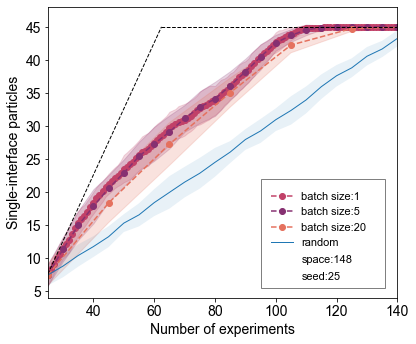

In [13]:
os.chdir(path)
palette = itertools.cycle(sns.color_palette(palette='flare', n_colors=3))
next(palette)
plt.figure(figsize=(6,5))
N_seed = 25

# This loop adds data from three batch sizes we studied to the plot:
for i in range(3):
    color=next(palette)
    merged1 = np.array([j for j in ucb_scenario_1_runs[i]])
    mu1 = np.mean(merged1, axis=0)
    std1 = np.std(merged1, axis=0)
    x1 = np.arange(0,len(merged1[0]))*batch_sizes[i]+N_seed
    plt.fill_between(x1, mu1+std1, mu1-std1, alpha=0.2, color=color)
    plt.plot(x1 ,mu1, 'o--', label='batch size:'+str(batch_sizes[i]),color=color)

# Here we add the random acquisition baseline.
merged1 = np.array([j for j in random_scenario_1_runs])
mu1 = np.mean(merged1, axis=0)
std1 = np.std(merged1, axis=0)
x1 = np.arange(0,len(merged1[0]))*5+N_seed
plt.fill_between(x1, mu1+std1, mu1-std1, alpha=0.1)
plt.plot(x1 ,mu1, label='random',linewidth=1)

# Here we add the ideal performance limits. Note we account for the average number of SINPs
# we would get in the seed in setting the limits.
plt.plot([45-sum(df.target==0)*25/148+N_seed,120+N_seed],[45,45],'k--',linewidth=1)
plt.plot([N_seed,45-sum(df.target==0)*25/148+N_seed],[sum(df.target==0)*25/148,45],'k--',linewidth=1)

plt.xlim(N_seed,140)
plt.ylabel("Single-interface particles")
plt.xlabel("Number of experiments")

# Let's add some relevant meta data:
plt.text(0.726, 0.1, 'space:148\nseed:25', linespacing=1.85,
         horizontalalignment='left', fontsize=11,
         verticalalignment='center', transform=plt.gca().transAxes)

plt.legend(fontsize=11,frameon=False,loc=(0.625,0.155))
rect = patches.Rectangle((95, 5.5), 41, 16.5, linewidth=1, edgecolor='grey', facecolor='w')
plt.gca().add_patch(rect)

plt.ylim(4,48)
plt.tight_layout()
plt.savefig('campaign_1.pdf',dpi=300)
plt.savefig('campaign_1.png',dpi=300)

We observe that the performance degradation with increasing batch size is small for EmbedCompGPUCB in SINP discovery,
and agentout performs the random baseline by a significant margin.

In the next plot, we compare the relative performance of our EmbedCompGPUCB in SINP discovery to standard UCB.

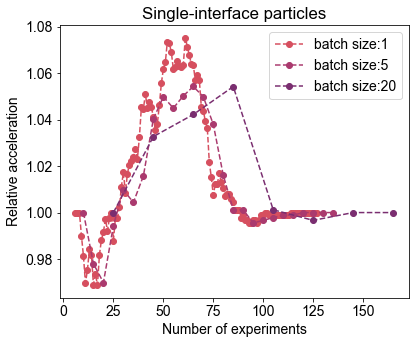

In [14]:
plt.figure(figsize=(6,5))
palette = itertools.cycle(sns.color_palette(palette='flare', n_colors=4))
next(palette)

# This loop adds data from the batch sizes we studied to the plot:
for r in range(len(ucb_scenario_1_runs)):
    color=next(palette)
    merged1 = np.array([j for j in ecucb_scenario_1_runs[r]])
    mu1 = np.mean(merged1, axis=0)
    std1 = np.std(merged1, axis=0)
    x1 = np.arange(1,len(merged1[0])+1)*batch_sizes[r]+5
    
    merged1p = np.array([j for j in ucb_scenario_1_runs[r]])
    mu1p = np.mean(merged1p, axis=0)
    std1p = np.std(merged1p, axis=0)
    x1p = np.arange(1,len(merged1p[0])+1)*batch_sizes[r]+5
    
    plt.plot(x1 ,mu1/mu1p, 'o--', label='batch size:'+str(batch_sizes[r]),color=color)

plt.legend()
plt.ylabel(r"Relative acceleration")
plt.title('Single-interface particles')
plt.xlabel("Number of experiments")
plt.tight_layout()
plt.savefig('acceleration_1.pdf',dpi=300)
plt.savefig('acceleration_1.png',dpi=300)

### Part 2.2 Simulations under Scenario #2
Here we demonstrate the simulation of our BO strategy for the Scenario #2 described in Wahl et al.: finding quaternary (n=4) or higher order SINPs from the
148 partcle dataset, using all data from n<4 as the seed, combined with 5 randomly sampled data points from n>=4.
This scenario is a more stringent test for the agent, as there are only 7 SINPs meeting the target out of a search space of 78 in this scenario.

Since the workflows are identical, we will minimize the amount of text and just generate all the helper functions that would run us the above described campaigns as we did for Scenario #1.

In [15]:
def random_scenario_2(i,n_query,max_budget):
    loop_dir = os.path.join(path,'random-s2-{}-{}'.format(n_query,i))
    os.mkdir(loop_dir)
    agent = RandomAgent(n_query=n_query)
    analyzer = GenericMaxAnalyzer(threshold=-.5)
    experiment = ATFSampler(featurized_df[ df.n_elems>=4 ])
    candidate_data = featurized_df
    seed_data = featurized_df[ df.n_elems<4 ]
    candidate_data = candidate_data.drop(seed_data.index)
    loop = Campaign(candidate_data, agent, experiment, seed_data=seed_data,
                    analyzer=analyzer,path=loop_dir,create_seed=False)
    loop.initialize(random_state=i)
    np.random.seed(i)
    loop.auto_loop(n_iterations=max_budget/n_query)
    return loop.analyzer.score 

In [16]:
random_scenario_2_runs  = Parallel(n_jobs=1)(delayed(random_scenario_2)(i,1,120) for i in range(20))

Campaign initialization state: Agent RandomAgent hypothesizing
Campaign 0 state: Running experiments
Iteration: 0
Campaign 0 state: Getting new results
Campaign 0 state: Analyzing results
Campaign 0 state: Agent RandomAgent hypothesizing
Campaign 0 state: Running experiments
  Waiting for next round ...
Iteration: 1
Campaign 1 state: Getting new results
Campaign 1 state: Analyzing results
Campaign 1 state: Agent RandomAgent hypothesizing
Campaign 1 state: Running experiments
  Waiting for next round ...
Iteration: 2
Campaign 2 state: Getting new results
Campaign 2 state: Analyzing results
Campaign 2 state: Agent RandomAgent hypothesizing
Campaign 2 state: Running experiments
  Waiting for next round ...
Iteration: 3
Campaign 3 state: Getting new results
Campaign 3 state: Analyzing results
Campaign 3 state: Agent RandomAgent hypothesizing
Campaign 3 state: Running experiments
  Waiting for next round ...
Iteration: 4
Campaign 4 state: Getting new results
Campaign 4 state: Analyzing resu

Iteration: 39
Campaign 39 state: Getting new results
Campaign 39 state: Analyzing results
Campaign 39 state: Agent RandomAgent hypothesizing
Campaign 39 state: Running experiments
  Waiting for next round ...
Iteration: 40
Campaign 40 state: Getting new results
Campaign 40 state: Analyzing results
Campaign 40 state: Agent RandomAgent hypothesizing
Campaign 40 state: Running experiments
  Waiting for next round ...
Iteration: 41
Campaign 41 state: Getting new results
Campaign 41 state: Analyzing results
Campaign 41 state: Agent RandomAgent hypothesizing
Campaign 41 state: Running experiments
  Waiting for next round ...
Iteration: 42
Campaign 42 state: Getting new results
Campaign 42 state: Analyzing results
Campaign 42 state: Agent RandomAgent hypothesizing
Campaign 42 state: Running experiments
  Waiting for next round ...
Iteration: 43
Campaign 43 state: Getting new results
Campaign 43 state: Analyzing results
Campaign 43 state: Agent RandomAgent hypothesizing
Campaign 43 state: Runn

Campaign initialization state: Agent RandomAgent hypothesizing
Campaign 0 state: Running experiments
Iteration: 0
Campaign 0 state: Getting new results
Campaign 0 state: Analyzing results
Campaign 0 state: Agent RandomAgent hypothesizing
Campaign 0 state: Running experiments
  Waiting for next round ...
Iteration: 1
Campaign 1 state: Getting new results
Campaign 1 state: Analyzing results
Campaign 1 state: Agent RandomAgent hypothesizing
Campaign 1 state: Running experiments
  Waiting for next round ...
Iteration: 2
Campaign 2 state: Getting new results
Campaign 2 state: Analyzing results
Campaign 2 state: Agent RandomAgent hypothesizing
Campaign 2 state: Running experiments
  Waiting for next round ...
Iteration: 3
Campaign 3 state: Getting new results
Campaign 3 state: Analyzing results
Campaign 3 state: Agent RandomAgent hypothesizing
Campaign 3 state: Running experiments
  Waiting for next round ...
Iteration: 4
Campaign 4 state: Getting new results
Campaign 4 state: Analyzing resu

Iteration: 39
Campaign 39 state: Getting new results
Campaign 39 state: Analyzing results
Campaign 39 state: Agent RandomAgent hypothesizing
Campaign 39 state: Running experiments
  Waiting for next round ...
Iteration: 40
Campaign 40 state: Getting new results
Campaign 40 state: Analyzing results
Campaign 40 state: Agent RandomAgent hypothesizing
Campaign 40 state: Running experiments
  Waiting for next round ...
Iteration: 41
Campaign 41 state: Getting new results
Campaign 41 state: Analyzing results
Campaign 41 state: Agent RandomAgent hypothesizing
Campaign 41 state: Running experiments
  Waiting for next round ...
Iteration: 42
Campaign 42 state: Getting new results
Campaign 42 state: Analyzing results
Campaign 42 state: Agent RandomAgent hypothesizing
Campaign 42 state: Running experiments
  Waiting for next round ...
Iteration: 43
Campaign 43 state: Getting new results
Campaign 43 state: Analyzing results
Campaign 43 state: Agent RandomAgent hypothesizing
Campaign 43 state: Runn

Campaign initialization state: Agent RandomAgent hypothesizing
Campaign 0 state: Running experiments
Iteration: 0
Campaign 0 state: Getting new results
Campaign 0 state: Analyzing results
Campaign 0 state: Agent RandomAgent hypothesizing
Campaign 0 state: Running experiments
  Waiting for next round ...
Iteration: 1
Campaign 1 state: Getting new results
Campaign 1 state: Analyzing results
Campaign 1 state: Agent RandomAgent hypothesizing
Campaign 1 state: Running experiments
  Waiting for next round ...
Iteration: 2
Campaign 2 state: Getting new results
Campaign 2 state: Analyzing results
Campaign 2 state: Agent RandomAgent hypothesizing
Campaign 2 state: Running experiments
  Waiting for next round ...
Iteration: 3
Campaign 3 state: Getting new results
Campaign 3 state: Analyzing results
Campaign 3 state: Agent RandomAgent hypothesizing
Campaign 3 state: Running experiments
  Waiting for next round ...
Iteration: 4
Campaign 4 state: Getting new results
Campaign 4 state: Analyzing resu

Iteration: 39
Campaign 39 state: Getting new results
Campaign 39 state: Analyzing results
Campaign 39 state: Agent RandomAgent hypothesizing
Campaign 39 state: Running experiments
  Waiting for next round ...
Iteration: 40
Campaign 40 state: Getting new results
Campaign 40 state: Analyzing results
Campaign 40 state: Agent RandomAgent hypothesizing
Campaign 40 state: Running experiments
  Waiting for next round ...
Iteration: 41
Campaign 41 state: Getting new results
Campaign 41 state: Analyzing results
Campaign 41 state: Agent RandomAgent hypothesizing
Campaign 41 state: Running experiments
  Waiting for next round ...
Iteration: 42
Campaign 42 state: Getting new results
Campaign 42 state: Analyzing results
Campaign 42 state: Agent RandomAgent hypothesizing
Campaign 42 state: Running experiments
  Waiting for next round ...
Iteration: 43
Campaign 43 state: Getting new results
Campaign 43 state: Analyzing results
Campaign 43 state: Agent RandomAgent hypothesizing
Campaign 43 state: Runn

Campaign initialization state: Agent RandomAgent hypothesizing
Campaign 0 state: Running experiments
Iteration: 0
Campaign 0 state: Getting new results
Campaign 0 state: Analyzing results
Campaign 0 state: Agent RandomAgent hypothesizing
Campaign 0 state: Running experiments
  Waiting for next round ...
Iteration: 1
Campaign 1 state: Getting new results
Campaign 1 state: Analyzing results
Campaign 1 state: Agent RandomAgent hypothesizing
Campaign 1 state: Running experiments
  Waiting for next round ...
Iteration: 2
Campaign 2 state: Getting new results
Campaign 2 state: Analyzing results
Campaign 2 state: Agent RandomAgent hypothesizing
Campaign 2 state: Running experiments
  Waiting for next round ...
Iteration: 3
Campaign 3 state: Getting new results
Campaign 3 state: Analyzing results
Campaign 3 state: Agent RandomAgent hypothesizing
Campaign 3 state: Running experiments
  Waiting for next round ...
Iteration: 4
Campaign 4 state: Getting new results
Campaign 4 state: Analyzing resu

Iteration: 39
Campaign 39 state: Getting new results
Campaign 39 state: Analyzing results
Campaign 39 state: Agent RandomAgent hypothesizing
Campaign 39 state: Running experiments
  Waiting for next round ...
Iteration: 40
Campaign 40 state: Getting new results
Campaign 40 state: Analyzing results
Campaign 40 state: Agent RandomAgent hypothesizing
Campaign 40 state: Running experiments
  Waiting for next round ...
Iteration: 41
Campaign 41 state: Getting new results
Campaign 41 state: Analyzing results
Campaign 41 state: Agent RandomAgent hypothesizing
Campaign 41 state: Running experiments
  Waiting for next round ...
Iteration: 42
Campaign 42 state: Getting new results
Campaign 42 state: Analyzing results
Campaign 42 state: Agent RandomAgent hypothesizing
Campaign 42 state: Running experiments
  Waiting for next round ...
Iteration: 43
Campaign 43 state: Getting new results
Campaign 43 state: Analyzing results
Campaign 43 state: Agent RandomAgent hypothesizing
Campaign 43 state: Runn

Campaign initialization state: Agent RandomAgent hypothesizing
Campaign 0 state: Running experiments
Iteration: 0
Campaign 0 state: Getting new results
Campaign 0 state: Analyzing results
Campaign 0 state: Agent RandomAgent hypothesizing
Campaign 0 state: Running experiments
  Waiting for next round ...
Iteration: 1
Campaign 1 state: Getting new results
Campaign 1 state: Analyzing results
Campaign 1 state: Agent RandomAgent hypothesizing
Campaign 1 state: Running experiments
  Waiting for next round ...
Iteration: 2
Campaign 2 state: Getting new results
Campaign 2 state: Analyzing results
Campaign 2 state: Agent RandomAgent hypothesizing
Campaign 2 state: Running experiments
  Waiting for next round ...
Iteration: 3
Campaign 3 state: Getting new results
Campaign 3 state: Analyzing results
Campaign 3 state: Agent RandomAgent hypothesizing
Campaign 3 state: Running experiments
  Waiting for next round ...
Iteration: 4
Campaign 4 state: Getting new results
Campaign 4 state: Analyzing resu

Iteration: 39
Campaign 39 state: Getting new results
Campaign 39 state: Analyzing results
Campaign 39 state: Agent RandomAgent hypothesizing
Campaign 39 state: Running experiments
  Waiting for next round ...
Iteration: 40
Campaign 40 state: Getting new results
Campaign 40 state: Analyzing results
Campaign 40 state: Agent RandomAgent hypothesizing
Campaign 40 state: Running experiments
  Waiting for next round ...
Iteration: 41
Campaign 41 state: Getting new results
Campaign 41 state: Analyzing results
Campaign 41 state: Agent RandomAgent hypothesizing
Campaign 41 state: Running experiments
  Waiting for next round ...
Iteration: 42
Campaign 42 state: Getting new results
Campaign 42 state: Analyzing results
Campaign 42 state: Agent RandomAgent hypothesizing
Campaign 42 state: Running experiments
  Waiting for next round ...
Iteration: 43
Campaign 43 state: Getting new results
Campaign 43 state: Analyzing results
Campaign 43 state: Agent RandomAgent hypothesizing
Campaign 43 state: Runn

Campaign initialization state: Agent RandomAgent hypothesizing
Campaign 0 state: Running experiments
Iteration: 0
Campaign 0 state: Getting new results
Campaign 0 state: Analyzing results
Campaign 0 state: Agent RandomAgent hypothesizing
Campaign 0 state: Running experiments
  Waiting for next round ...
Iteration: 1
Campaign 1 state: Getting new results
Campaign 1 state: Analyzing results
Campaign 1 state: Agent RandomAgent hypothesizing
Campaign 1 state: Running experiments
  Waiting for next round ...
Iteration: 2
Campaign 2 state: Getting new results
Campaign 2 state: Analyzing results
Campaign 2 state: Agent RandomAgent hypothesizing
Campaign 2 state: Running experiments
  Waiting for next round ...
Iteration: 3
Campaign 3 state: Getting new results
Campaign 3 state: Analyzing results
Campaign 3 state: Agent RandomAgent hypothesizing
Campaign 3 state: Running experiments
  Waiting for next round ...
Iteration: 4
Campaign 4 state: Getting new results
Campaign 4 state: Analyzing resu

Iteration: 39
Campaign 39 state: Getting new results
Campaign 39 state: Analyzing results
Campaign 39 state: Agent RandomAgent hypothesizing
Campaign 39 state: Running experiments
  Waiting for next round ...
Iteration: 40
Campaign 40 state: Getting new results
Campaign 40 state: Analyzing results
Campaign 40 state: Agent RandomAgent hypothesizing
Campaign 40 state: Running experiments
  Waiting for next round ...
Iteration: 41
Campaign 41 state: Getting new results
Campaign 41 state: Analyzing results
Campaign 41 state: Agent RandomAgent hypothesizing
Campaign 41 state: Running experiments
  Waiting for next round ...
Iteration: 42
Campaign 42 state: Getting new results
Campaign 42 state: Analyzing results
Campaign 42 state: Agent RandomAgent hypothesizing
Campaign 42 state: Running experiments
  Waiting for next round ...
Iteration: 43
Campaign 43 state: Getting new results
Campaign 43 state: Analyzing results
Campaign 43 state: Agent RandomAgent hypothesizing
Campaign 43 state: Runn

Campaign initialization state: Agent RandomAgent hypothesizing
Campaign 0 state: Running experiments
Iteration: 0
Campaign 0 state: Getting new results
Campaign 0 state: Analyzing results
Campaign 0 state: Agent RandomAgent hypothesizing
Campaign 0 state: Running experiments
  Waiting for next round ...
Iteration: 1
Campaign 1 state: Getting new results
Campaign 1 state: Analyzing results
Campaign 1 state: Agent RandomAgent hypothesizing
Campaign 1 state: Running experiments
  Waiting for next round ...
Iteration: 2
Campaign 2 state: Getting new results
Campaign 2 state: Analyzing results
Campaign 2 state: Agent RandomAgent hypothesizing
Campaign 2 state: Running experiments
  Waiting for next round ...
Iteration: 3
Campaign 3 state: Getting new results
Campaign 3 state: Analyzing results
Campaign 3 state: Agent RandomAgent hypothesizing
Campaign 3 state: Running experiments
  Waiting for next round ...
Iteration: 4
Campaign 4 state: Getting new results
Campaign 4 state: Analyzing resu

Iteration: 39
Campaign 39 state: Getting new results
Campaign 39 state: Analyzing results
Campaign 39 state: Agent RandomAgent hypothesizing
Campaign 39 state: Running experiments
  Waiting for next round ...
Iteration: 40
Campaign 40 state: Getting new results
Campaign 40 state: Analyzing results
Campaign 40 state: Agent RandomAgent hypothesizing
Campaign 40 state: Running experiments
  Waiting for next round ...
Iteration: 41
Campaign 41 state: Getting new results
Campaign 41 state: Analyzing results
Campaign 41 state: Agent RandomAgent hypothesizing
Campaign 41 state: Running experiments
  Waiting for next round ...
Iteration: 42
Campaign 42 state: Getting new results
Campaign 42 state: Analyzing results
Campaign 42 state: Agent RandomAgent hypothesizing
Campaign 42 state: Running experiments
  Waiting for next round ...
Iteration: 43
Campaign 43 state: Getting new results
Campaign 43 state: Analyzing results
Campaign 43 state: Agent RandomAgent hypothesizing
Campaign 43 state: Runn

Campaign initialization state: Agent RandomAgent hypothesizing
Campaign 0 state: Running experiments
Iteration: 0
Campaign 0 state: Getting new results
Campaign 0 state: Analyzing results
Campaign 0 state: Agent RandomAgent hypothesizing
Campaign 0 state: Running experiments
  Waiting for next round ...
Iteration: 1
Campaign 1 state: Getting new results
Campaign 1 state: Analyzing results
Campaign 1 state: Agent RandomAgent hypothesizing
Campaign 1 state: Running experiments
  Waiting for next round ...
Iteration: 2
Campaign 2 state: Getting new results
Campaign 2 state: Analyzing results
Campaign 2 state: Agent RandomAgent hypothesizing
Campaign 2 state: Running experiments
  Waiting for next round ...
Iteration: 3
Campaign 3 state: Getting new results
Campaign 3 state: Analyzing results
Campaign 3 state: Agent RandomAgent hypothesizing
Campaign 3 state: Running experiments
  Waiting for next round ...
Iteration: 4
Campaign 4 state: Getting new results
Campaign 4 state: Analyzing resu

Iteration: 39
Campaign 39 state: Getting new results
Campaign 39 state: Analyzing results
Campaign 39 state: Agent RandomAgent hypothesizing
Campaign 39 state: Running experiments
  Waiting for next round ...
Iteration: 40
Campaign 40 state: Getting new results
Campaign 40 state: Analyzing results
Campaign 40 state: Agent RandomAgent hypothesizing
Campaign 40 state: Running experiments
  Waiting for next round ...
Iteration: 41
Campaign 41 state: Getting new results
Campaign 41 state: Analyzing results
Campaign 41 state: Agent RandomAgent hypothesizing
Campaign 41 state: Running experiments
  Waiting for next round ...
Iteration: 42
Campaign 42 state: Getting new results
Campaign 42 state: Analyzing results
Campaign 42 state: Agent RandomAgent hypothesizing
Campaign 42 state: Running experiments
  Waiting for next round ...
Iteration: 43
Campaign 43 state: Getting new results
Campaign 43 state: Analyzing results
Campaign 43 state: Agent RandomAgent hypothesizing
Campaign 43 state: Runn

Campaign initialization state: Agent RandomAgent hypothesizing
Campaign 0 state: Running experiments
Iteration: 0
Campaign 0 state: Getting new results
Campaign 0 state: Analyzing results
Campaign 0 state: Agent RandomAgent hypothesizing
Campaign 0 state: Running experiments
  Waiting for next round ...
Iteration: 1
Campaign 1 state: Getting new results
Campaign 1 state: Analyzing results
Campaign 1 state: Agent RandomAgent hypothesizing
Campaign 1 state: Running experiments
  Waiting for next round ...
Iteration: 2
Campaign 2 state: Getting new results
Campaign 2 state: Analyzing results
Campaign 2 state: Agent RandomAgent hypothesizing
Campaign 2 state: Running experiments
  Waiting for next round ...
Iteration: 3
Campaign 3 state: Getting new results
Campaign 3 state: Analyzing results
Campaign 3 state: Agent RandomAgent hypothesizing
Campaign 3 state: Running experiments
  Waiting for next round ...
Iteration: 4
Campaign 4 state: Getting new results
Campaign 4 state: Analyzing resu

Iteration: 39
Campaign 39 state: Getting new results
Campaign 39 state: Analyzing results
Campaign 39 state: Agent RandomAgent hypothesizing
Campaign 39 state: Running experiments
  Waiting for next round ...
Iteration: 40
Campaign 40 state: Getting new results
Campaign 40 state: Analyzing results
Campaign 40 state: Agent RandomAgent hypothesizing
Campaign 40 state: Running experiments
  Waiting for next round ...
Iteration: 41
Campaign 41 state: Getting new results
Campaign 41 state: Analyzing results
Campaign 41 state: Agent RandomAgent hypothesizing
Campaign 41 state: Running experiments
  Waiting for next round ...
Iteration: 42
Campaign 42 state: Getting new results
Campaign 42 state: Analyzing results
Campaign 42 state: Agent RandomAgent hypothesizing
Campaign 42 state: Running experiments
  Waiting for next round ...
Iteration: 43
Campaign 43 state: Getting new results
Campaign 43 state: Analyzing results
Campaign 43 state: Agent RandomAgent hypothesizing
Campaign 43 state: Runn

Campaign initialization state: Agent RandomAgent hypothesizing
Campaign 0 state: Running experiments
Iteration: 0
Campaign 0 state: Getting new results
Campaign 0 state: Analyzing results
Campaign 0 state: Agent RandomAgent hypothesizing
Campaign 0 state: Running experiments
  Waiting for next round ...
Iteration: 1
Campaign 1 state: Getting new results
Campaign 1 state: Analyzing results
Campaign 1 state: Agent RandomAgent hypothesizing
Campaign 1 state: Running experiments
  Waiting for next round ...
Iteration: 2
Campaign 2 state: Getting new results
Campaign 2 state: Analyzing results
Campaign 2 state: Agent RandomAgent hypothesizing
Campaign 2 state: Running experiments
  Waiting for next round ...
Iteration: 3
Campaign 3 state: Getting new results
Campaign 3 state: Analyzing results
Campaign 3 state: Agent RandomAgent hypothesizing
Campaign 3 state: Running experiments
  Waiting for next round ...
Iteration: 4
Campaign 4 state: Getting new results
Campaign 4 state: Analyzing resu

Iteration: 39
Campaign 39 state: Getting new results
Campaign 39 state: Analyzing results
Campaign 39 state: Agent RandomAgent hypothesizing
Campaign 39 state: Running experiments
  Waiting for next round ...
Iteration: 40
Campaign 40 state: Getting new results
Campaign 40 state: Analyzing results
Campaign 40 state: Agent RandomAgent hypothesizing
Campaign 40 state: Running experiments
  Waiting for next round ...
Iteration: 41
Campaign 41 state: Getting new results
Campaign 41 state: Analyzing results
Campaign 41 state: Agent RandomAgent hypothesizing
Campaign 41 state: Running experiments
  Waiting for next round ...
Iteration: 42
Campaign 42 state: Getting new results
Campaign 42 state: Analyzing results
Campaign 42 state: Agent RandomAgent hypothesizing
Campaign 42 state: Running experiments
  Waiting for next round ...
Iteration: 43
Campaign 43 state: Getting new results
Campaign 43 state: Analyzing results
Campaign 43 state: Agent RandomAgent hypothesizing
Campaign 43 state: Runn

Campaign initialization state: Agent RandomAgent hypothesizing
Campaign 0 state: Running experiments
Iteration: 0
Campaign 0 state: Getting new results
Campaign 0 state: Analyzing results
Campaign 0 state: Agent RandomAgent hypothesizing
Campaign 0 state: Running experiments
  Waiting for next round ...
Iteration: 1
Campaign 1 state: Getting new results
Campaign 1 state: Analyzing results
Campaign 1 state: Agent RandomAgent hypothesizing
Campaign 1 state: Running experiments
  Waiting for next round ...
Iteration: 2
Campaign 2 state: Getting new results
Campaign 2 state: Analyzing results
Campaign 2 state: Agent RandomAgent hypothesizing
Campaign 2 state: Running experiments
  Waiting for next round ...
Iteration: 3
Campaign 3 state: Getting new results
Campaign 3 state: Analyzing results
Campaign 3 state: Agent RandomAgent hypothesizing
Campaign 3 state: Running experiments
  Waiting for next round ...
Iteration: 4
Campaign 4 state: Getting new results
Campaign 4 state: Analyzing resu

Iteration: 39
Campaign 39 state: Getting new results
Campaign 39 state: Analyzing results
Campaign 39 state: Agent RandomAgent hypothesizing
Campaign 39 state: Running experiments
  Waiting for next round ...
Iteration: 40
Campaign 40 state: Getting new results
Campaign 40 state: Analyzing results
Campaign 40 state: Agent RandomAgent hypothesizing
Campaign 40 state: Running experiments
  Waiting for next round ...
Iteration: 41
Campaign 41 state: Getting new results
Campaign 41 state: Analyzing results
Campaign 41 state: Agent RandomAgent hypothesizing
Campaign 41 state: Running experiments
  Waiting for next round ...
Iteration: 42
Campaign 42 state: Getting new results
Campaign 42 state: Analyzing results
Campaign 42 state: Agent RandomAgent hypothesizing
Campaign 42 state: Running experiments
  Waiting for next round ...
Iteration: 43
Campaign 43 state: Getting new results
Campaign 43 state: Analyzing results
Campaign 43 state: Agent RandomAgent hypothesizing
Campaign 43 state: Runn

Campaign initialization state: Agent RandomAgent hypothesizing
Campaign 0 state: Running experiments
Iteration: 0
Campaign 0 state: Getting new results
Campaign 0 state: Analyzing results
Campaign 0 state: Agent RandomAgent hypothesizing
Campaign 0 state: Running experiments
  Waiting for next round ...
Iteration: 1
Campaign 1 state: Getting new results
Campaign 1 state: Analyzing results
Campaign 1 state: Agent RandomAgent hypothesizing
Campaign 1 state: Running experiments
  Waiting for next round ...
Iteration: 2
Campaign 2 state: Getting new results
Campaign 2 state: Analyzing results
Campaign 2 state: Agent RandomAgent hypothesizing
Campaign 2 state: Running experiments
  Waiting for next round ...
Iteration: 3
Campaign 3 state: Getting new results
Campaign 3 state: Analyzing results
Campaign 3 state: Agent RandomAgent hypothesizing
Campaign 3 state: Running experiments
  Waiting for next round ...
Iteration: 4
Campaign 4 state: Getting new results
Campaign 4 state: Analyzing resu

Iteration: 39
Campaign 39 state: Getting new results
Campaign 39 state: Analyzing results
Campaign 39 state: Agent RandomAgent hypothesizing
Campaign 39 state: Running experiments
  Waiting for next round ...
Iteration: 40
Campaign 40 state: Getting new results
Campaign 40 state: Analyzing results
Campaign 40 state: Agent RandomAgent hypothesizing
Campaign 40 state: Running experiments
  Waiting for next round ...
Iteration: 41
Campaign 41 state: Getting new results
Campaign 41 state: Analyzing results
Campaign 41 state: Agent RandomAgent hypothesizing
Campaign 41 state: Running experiments
  Waiting for next round ...
Iteration: 42
Campaign 42 state: Getting new results
Campaign 42 state: Analyzing results
Campaign 42 state: Agent RandomAgent hypothesizing
Campaign 42 state: Running experiments
  Waiting for next round ...
Iteration: 43
Campaign 43 state: Getting new results
Campaign 43 state: Analyzing results
Campaign 43 state: Agent RandomAgent hypothesizing
Campaign 43 state: Runn

Campaign initialization state: Agent RandomAgent hypothesizing
Campaign 0 state: Running experiments
Iteration: 0
Campaign 0 state: Getting new results
Campaign 0 state: Analyzing results
Campaign 0 state: Agent RandomAgent hypothesizing
Campaign 0 state: Running experiments
  Waiting for next round ...
Iteration: 1
Campaign 1 state: Getting new results
Campaign 1 state: Analyzing results
Campaign 1 state: Agent RandomAgent hypothesizing
Campaign 1 state: Running experiments
  Waiting for next round ...
Iteration: 2
Campaign 2 state: Getting new results
Campaign 2 state: Analyzing results
Campaign 2 state: Agent RandomAgent hypothesizing
Campaign 2 state: Running experiments
  Waiting for next round ...
Iteration: 3
Campaign 3 state: Getting new results
Campaign 3 state: Analyzing results
Campaign 3 state: Agent RandomAgent hypothesizing
Campaign 3 state: Running experiments
  Waiting for next round ...
Iteration: 4
Campaign 4 state: Getting new results
Campaign 4 state: Analyzing resu

Iteration: 39
Campaign 39 state: Getting new results
Campaign 39 state: Analyzing results
Campaign 39 state: Agent RandomAgent hypothesizing
Campaign 39 state: Running experiments
  Waiting for next round ...
Iteration: 40
Campaign 40 state: Getting new results
Campaign 40 state: Analyzing results
Campaign 40 state: Agent RandomAgent hypothesizing
Campaign 40 state: Running experiments
  Waiting for next round ...
Iteration: 41
Campaign 41 state: Getting new results
Campaign 41 state: Analyzing results
Campaign 41 state: Agent RandomAgent hypothesizing
Campaign 41 state: Running experiments
  Waiting for next round ...
Iteration: 42
Campaign 42 state: Getting new results
Campaign 42 state: Analyzing results
Campaign 42 state: Agent RandomAgent hypothesizing
Campaign 42 state: Running experiments
  Waiting for next round ...
Iteration: 43
Campaign 43 state: Getting new results
Campaign 43 state: Analyzing results
Campaign 43 state: Agent RandomAgent hypothesizing
Campaign 43 state: Runn

Campaign initialization state: Agent RandomAgent hypothesizing
Campaign 0 state: Running experiments
Iteration: 0
Campaign 0 state: Getting new results
Campaign 0 state: Analyzing results
Campaign 0 state: Agent RandomAgent hypothesizing
Campaign 0 state: Running experiments
  Waiting for next round ...
Iteration: 1
Campaign 1 state: Getting new results
Campaign 1 state: Analyzing results
Campaign 1 state: Agent RandomAgent hypothesizing
Campaign 1 state: Running experiments
  Waiting for next round ...
Iteration: 2
Campaign 2 state: Getting new results
Campaign 2 state: Analyzing results
Campaign 2 state: Agent RandomAgent hypothesizing
Campaign 2 state: Running experiments
  Waiting for next round ...
Iteration: 3
Campaign 3 state: Getting new results
Campaign 3 state: Analyzing results
Campaign 3 state: Agent RandomAgent hypothesizing
Campaign 3 state: Running experiments
  Waiting for next round ...
Iteration: 4
Campaign 4 state: Getting new results
Campaign 4 state: Analyzing resu

Iteration: 39
Campaign 39 state: Getting new results
Campaign 39 state: Analyzing results
Campaign 39 state: Agent RandomAgent hypothesizing
Campaign 39 state: Running experiments
  Waiting for next round ...
Iteration: 40
Campaign 40 state: Getting new results
Campaign 40 state: Analyzing results
Campaign 40 state: Agent RandomAgent hypothesizing
Campaign 40 state: Running experiments
  Waiting for next round ...
Iteration: 41
Campaign 41 state: Getting new results
Campaign 41 state: Analyzing results
Campaign 41 state: Agent RandomAgent hypothesizing
Campaign 41 state: Running experiments
  Waiting for next round ...
Iteration: 42
Campaign 42 state: Getting new results
Campaign 42 state: Analyzing results
Campaign 42 state: Agent RandomAgent hypothesizing
Campaign 42 state: Running experiments
  Waiting for next round ...
Iteration: 43
Campaign 43 state: Getting new results
Campaign 43 state: Analyzing results
Campaign 43 state: Agent RandomAgent hypothesizing
Campaign 43 state: Runn

Campaign initialization state: Agent RandomAgent hypothesizing
Campaign 0 state: Running experiments
Iteration: 0
Campaign 0 state: Getting new results
Campaign 0 state: Analyzing results
Campaign 0 state: Agent RandomAgent hypothesizing
Campaign 0 state: Running experiments
  Waiting for next round ...
Iteration: 1
Campaign 1 state: Getting new results
Campaign 1 state: Analyzing results
Campaign 1 state: Agent RandomAgent hypothesizing
Campaign 1 state: Running experiments
  Waiting for next round ...
Iteration: 2
Campaign 2 state: Getting new results
Campaign 2 state: Analyzing results
Campaign 2 state: Agent RandomAgent hypothesizing
Campaign 2 state: Running experiments
  Waiting for next round ...
Iteration: 3
Campaign 3 state: Getting new results
Campaign 3 state: Analyzing results
Campaign 3 state: Agent RandomAgent hypothesizing
Campaign 3 state: Running experiments
  Waiting for next round ...
Iteration: 4
Campaign 4 state: Getting new results
Campaign 4 state: Analyzing resu

Iteration: 39
Campaign 39 state: Getting new results
Campaign 39 state: Analyzing results
Campaign 39 state: Agent RandomAgent hypothesizing
Campaign 39 state: Running experiments
  Waiting for next round ...
Iteration: 40
Campaign 40 state: Getting new results
Campaign 40 state: Analyzing results
Campaign 40 state: Agent RandomAgent hypothesizing
Campaign 40 state: Running experiments
  Waiting for next round ...
Iteration: 41
Campaign 41 state: Getting new results
Campaign 41 state: Analyzing results
Campaign 41 state: Agent RandomAgent hypothesizing
Campaign 41 state: Running experiments
  Waiting for next round ...
Iteration: 42
Campaign 42 state: Getting new results
Campaign 42 state: Analyzing results
Campaign 42 state: Agent RandomAgent hypothesizing
Campaign 42 state: Running experiments
  Waiting for next round ...
Iteration: 43
Campaign 43 state: Getting new results
Campaign 43 state: Analyzing results
Campaign 43 state: Agent RandomAgent hypothesizing
Campaign 43 state: Runn

Campaign initialization state: Agent RandomAgent hypothesizing
Campaign 0 state: Running experiments
Iteration: 0
Campaign 0 state: Getting new results
Campaign 0 state: Analyzing results
Campaign 0 state: Agent RandomAgent hypothesizing
Campaign 0 state: Running experiments
  Waiting for next round ...
Iteration: 1
Campaign 1 state: Getting new results
Campaign 1 state: Analyzing results
Campaign 1 state: Agent RandomAgent hypothesizing
Campaign 1 state: Running experiments
  Waiting for next round ...
Iteration: 2
Campaign 2 state: Getting new results
Campaign 2 state: Analyzing results
Campaign 2 state: Agent RandomAgent hypothesizing
Campaign 2 state: Running experiments
  Waiting for next round ...
Iteration: 3
Campaign 3 state: Getting new results
Campaign 3 state: Analyzing results
Campaign 3 state: Agent RandomAgent hypothesizing
Campaign 3 state: Running experiments
  Waiting for next round ...
Iteration: 4
Campaign 4 state: Getting new results
Campaign 4 state: Analyzing resu

Iteration: 39
Campaign 39 state: Getting new results
Campaign 39 state: Analyzing results
Campaign 39 state: Agent RandomAgent hypothesizing
Campaign 39 state: Running experiments
  Waiting for next round ...
Iteration: 40
Campaign 40 state: Getting new results
Campaign 40 state: Analyzing results
Campaign 40 state: Agent RandomAgent hypothesizing
Campaign 40 state: Running experiments
  Waiting for next round ...
Iteration: 41
Campaign 41 state: Getting new results
Campaign 41 state: Analyzing results
Campaign 41 state: Agent RandomAgent hypothesizing
Campaign 41 state: Running experiments
  Waiting for next round ...
Iteration: 42
Campaign 42 state: Getting new results
Campaign 42 state: Analyzing results
Campaign 42 state: Agent RandomAgent hypothesizing
Campaign 42 state: Running experiments
  Waiting for next round ...
Iteration: 43
Campaign 43 state: Getting new results
Campaign 43 state: Analyzing results
Campaign 43 state: Agent RandomAgent hypothesizing
Campaign 43 state: Runn

Campaign initialization state: Agent RandomAgent hypothesizing
Campaign 0 state: Running experiments
Iteration: 0
Campaign 0 state: Getting new results
Campaign 0 state: Analyzing results
Campaign 0 state: Agent RandomAgent hypothesizing
Campaign 0 state: Running experiments
  Waiting for next round ...
Iteration: 1
Campaign 1 state: Getting new results
Campaign 1 state: Analyzing results
Campaign 1 state: Agent RandomAgent hypothesizing
Campaign 1 state: Running experiments
  Waiting for next round ...
Iteration: 2
Campaign 2 state: Getting new results
Campaign 2 state: Analyzing results
Campaign 2 state: Agent RandomAgent hypothesizing
Campaign 2 state: Running experiments
  Waiting for next round ...
Iteration: 3
Campaign 3 state: Getting new results
Campaign 3 state: Analyzing results
Campaign 3 state: Agent RandomAgent hypothesizing
Campaign 3 state: Running experiments
  Waiting for next round ...
Iteration: 4
Campaign 4 state: Getting new results
Campaign 4 state: Analyzing resu

Iteration: 39
Campaign 39 state: Getting new results
Campaign 39 state: Analyzing results
Campaign 39 state: Agent RandomAgent hypothesizing
Campaign 39 state: Running experiments
  Waiting for next round ...
Iteration: 40
Campaign 40 state: Getting new results
Campaign 40 state: Analyzing results
Campaign 40 state: Agent RandomAgent hypothesizing
Campaign 40 state: Running experiments
  Waiting for next round ...
Iteration: 41
Campaign 41 state: Getting new results
Campaign 41 state: Analyzing results
Campaign 41 state: Agent RandomAgent hypothesizing
Campaign 41 state: Running experiments
  Waiting for next round ...
Iteration: 42
Campaign 42 state: Getting new results
Campaign 42 state: Analyzing results
Campaign 42 state: Agent RandomAgent hypothesizing
Campaign 42 state: Running experiments
  Waiting for next round ...
Iteration: 43
Campaign 43 state: Getting new results
Campaign 43 state: Analyzing results
Campaign 43 state: Agent RandomAgent hypothesizing
Campaign 43 state: Runn

Campaign initialization state: Agent RandomAgent hypothesizing
Campaign 0 state: Running experiments
Iteration: 0
Campaign 0 state: Getting new results
Campaign 0 state: Analyzing results
Campaign 0 state: Agent RandomAgent hypothesizing
Campaign 0 state: Running experiments
  Waiting for next round ...
Iteration: 1
Campaign 1 state: Getting new results
Campaign 1 state: Analyzing results
Campaign 1 state: Agent RandomAgent hypothesizing
Campaign 1 state: Running experiments
  Waiting for next round ...
Iteration: 2
Campaign 2 state: Getting new results
Campaign 2 state: Analyzing results
Campaign 2 state: Agent RandomAgent hypothesizing
Campaign 2 state: Running experiments
  Waiting for next round ...
Iteration: 3
Campaign 3 state: Getting new results
Campaign 3 state: Analyzing results
Campaign 3 state: Agent RandomAgent hypothesizing
Campaign 3 state: Running experiments
  Waiting for next round ...
Iteration: 4
Campaign 4 state: Getting new results
Campaign 4 state: Analyzing resu

Iteration: 39
Campaign 39 state: Getting new results
Campaign 39 state: Analyzing results
Campaign 39 state: Agent RandomAgent hypothesizing
Campaign 39 state: Running experiments
  Waiting for next round ...
Iteration: 40
Campaign 40 state: Getting new results
Campaign 40 state: Analyzing results
Campaign 40 state: Agent RandomAgent hypothesizing
Campaign 40 state: Running experiments
  Waiting for next round ...
Iteration: 41
Campaign 41 state: Getting new results
Campaign 41 state: Analyzing results
Campaign 41 state: Agent RandomAgent hypothesizing
Campaign 41 state: Running experiments
  Waiting for next round ...
Iteration: 42
Campaign 42 state: Getting new results
Campaign 42 state: Analyzing results
Campaign 42 state: Agent RandomAgent hypothesizing
Campaign 42 state: Running experiments
  Waiting for next round ...
Iteration: 43
Campaign 43 state: Getting new results
Campaign 43 state: Analyzing results
Campaign 43 state: Agent RandomAgent hypothesizing
Campaign 43 state: Runn

Campaign initialization state: Agent RandomAgent hypothesizing
Campaign 0 state: Running experiments
Iteration: 0
Campaign 0 state: Getting new results
Campaign 0 state: Analyzing results
Campaign 0 state: Agent RandomAgent hypothesizing
Campaign 0 state: Running experiments
  Waiting for next round ...
Iteration: 1
Campaign 1 state: Getting new results
Campaign 1 state: Analyzing results
Campaign 1 state: Agent RandomAgent hypothesizing
Campaign 1 state: Running experiments
  Waiting for next round ...
Iteration: 2
Campaign 2 state: Getting new results
Campaign 2 state: Analyzing results
Campaign 2 state: Agent RandomAgent hypothesizing
Campaign 2 state: Running experiments
  Waiting for next round ...
Iteration: 3
Campaign 3 state: Getting new results
Campaign 3 state: Analyzing results
Campaign 3 state: Agent RandomAgent hypothesizing
Campaign 3 state: Running experiments
  Waiting for next round ...
Iteration: 4
Campaign 4 state: Getting new results
Campaign 4 state: Analyzing resu

Iteration: 39
Campaign 39 state: Getting new results
Campaign 39 state: Analyzing results
Campaign 39 state: Agent RandomAgent hypothesizing
Campaign 39 state: Running experiments
  Waiting for next round ...
Iteration: 40
Campaign 40 state: Getting new results
Campaign 40 state: Analyzing results
Campaign 40 state: Agent RandomAgent hypothesizing
Campaign 40 state: Running experiments
  Waiting for next round ...
Iteration: 41
Campaign 41 state: Getting new results
Campaign 41 state: Analyzing results
Campaign 41 state: Agent RandomAgent hypothesizing
Campaign 41 state: Running experiments
  Waiting for next round ...
Iteration: 42
Campaign 42 state: Getting new results
Campaign 42 state: Analyzing results
Campaign 42 state: Agent RandomAgent hypothesizing
Campaign 42 state: Running experiments
  Waiting for next round ...
Iteration: 43
Campaign 43 state: Getting new results
Campaign 43 state: Analyzing results
Campaign 43 state: Agent RandomAgent hypothesizing
Campaign 43 state: Runn

Campaign initialization state: Agent RandomAgent hypothesizing
Campaign 0 state: Running experiments
Iteration: 0
Campaign 0 state: Getting new results
Campaign 0 state: Analyzing results
Campaign 0 state: Agent RandomAgent hypothesizing
Campaign 0 state: Running experiments
  Waiting for next round ...
Iteration: 1
Campaign 1 state: Getting new results
Campaign 1 state: Analyzing results
Campaign 1 state: Agent RandomAgent hypothesizing
Campaign 1 state: Running experiments
  Waiting for next round ...
Iteration: 2
Campaign 2 state: Getting new results
Campaign 2 state: Analyzing results
Campaign 2 state: Agent RandomAgent hypothesizing
Campaign 2 state: Running experiments
  Waiting for next round ...
Iteration: 3
Campaign 3 state: Getting new results
Campaign 3 state: Analyzing results
Campaign 3 state: Agent RandomAgent hypothesizing
Campaign 3 state: Running experiments
  Waiting for next round ...
Iteration: 4
Campaign 4 state: Getting new results
Campaign 4 state: Analyzing resu

Iteration: 39
Campaign 39 state: Getting new results
Campaign 39 state: Analyzing results
Campaign 39 state: Agent RandomAgent hypothesizing
Campaign 39 state: Running experiments
  Waiting for next round ...
Iteration: 40
Campaign 40 state: Getting new results
Campaign 40 state: Analyzing results
Campaign 40 state: Agent RandomAgent hypothesizing
Campaign 40 state: Running experiments
  Waiting for next round ...
Iteration: 41
Campaign 41 state: Getting new results
Campaign 41 state: Analyzing results
Campaign 41 state: Agent RandomAgent hypothesizing
Campaign 41 state: Running experiments
  Waiting for next round ...
Iteration: 42
Campaign 42 state: Getting new results
Campaign 42 state: Analyzing results
Campaign 42 state: Agent RandomAgent hypothesizing
Campaign 42 state: Running experiments
  Waiting for next round ...
Iteration: 43
Campaign 43 state: Getting new results
Campaign 43 state: Analyzing results
Campaign 43 state: Agent RandomAgent hypothesizing
Campaign 43 state: Runn

Let's simulate the BO agents as well.

In [17]:
@wrap_non_picklable_objects
def ecucb_scenario_2(i,n_query,max_budget):
    loop_dir = os.path.join(path,'ecucb-s2-{}-{}'.format(n_query,i))
    os.mkdir(loop_dir)
    agent = EmbedCompGPUCB(n_query=n_query)
    analyzer = GenericMaxAnalyzer(threshold=-.5)
    experiment = ATFSampler(featurized_df[ df.n_elems>=4 ])
    candidate_data = featurized_df
    
    # define our seed:
    N_seed = 5
    seed_data = featurized_df[ df.n_elems<4 ]
    seed_data = seed_data.append(featurized_df[ df.n_elems>=4 ].sample(N_seed, random_state=i))
    
    candidate_data = candidate_data.drop(seed_data.index)
    
    loop = Campaign(candidate_data, agent, experiment, seed_data=seed_data,
                    analyzer=analyzer,path=loop_dir,create_seed=False)
    
    loop.initialize(random_state=i)
    loop.auto_loop(n_iterations=max_budget/n_query)
    return loop.analyzer.score 

@wrap_non_picklable_objects
def ucb_scenario_2(i,n_query,max_budget):
    loop_dir = os.path.join(path,'ucb-s2-{}-{}'.format(n_query,i))
    os.mkdir(loop_dir)
    agent = GPBatchUCB(n_query=n_query, mode='batch', alpha='auto')
    analyzer = GenericMaxAnalyzer(threshold=-.5)
    experiment = ATFSampler(df_plain[ df.n_elems>=4 ])
    candidate_data = df_plain # note we are optimizing over compositions directly.
    
    # define our seed:
    N_seed = 5
    seed_data = df_plain[ df.n_elems<4 ]
    seed_data = seed_data.append(df_plain[ df.n_elems>=4 ].sample(N_seed, random_state=i))
    
    candidate_data = candidate_data.drop(seed_data.index)
    
    loop = Campaign(candidate_data, agent, experiment, seed_data=seed_data,
                    analyzer=analyzer,path=loop_dir,create_seed=False)
    
    loop.initialize(random_state=i)
    loop.auto_loop(n_iterations=max_budget/n_query)
    return loop.analyzer.score 

Let's simulate campaigns  both types of agents. We'll test this time batch sizes of 1,3 and 5.

In [18]:
batch_sizes_2 = [1,3,5]

In [19]:
ecucb_scenario_2_runs = []
for n_query in batch_sizes_2:
    results = Parallel(n_jobs=-1)(delayed(ecucb_scenario_2)(i,n_query,120) for i in range(20))
    ecucb_scenario_2_runs.append(results)

In [20]:
ucb_scenario_2_runs = []
for n_query in batch_sizes_2:
    results = Parallel(n_jobs=-1)(delayed(ucb_scenario_2)(i,n_query,120) for i in range(20))
    ucb_scenario_2_runs.append(results)

We will make similar plots as before:

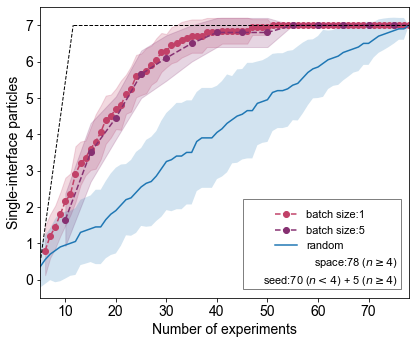

In [21]:
os.chdir(path)
palette = itertools.cycle(sns.color_palette(palette='flare', n_colors=3))
next(palette)
plt.figure(figsize=(6,5))
N_seed = 25

# This loop adds data from three batch sizes we studied to the plot:
for i in range(3):
    # Let's skip batch=3 for a more clear plot.
    if i==1:
        continue
    color=next(palette)
    merged1 = np.array([j for j in ecucb_scenario_2_runs[i]])
    mu1 = np.mean(merged1, axis=0)-38
    std1 = np.std(merged1, axis=0)
    x1 = np.arange(1,len(merged1[0])+1)*batch_sizes_2[i]+5
    plt.fill_between(x1, mu1+std1, mu1-std1, alpha=0.2,color=color)
    plt.plot(x1 ,mu1, 'o--', label='batch size:'+str(batch_sizes_2[i]),color=color)

# Here we add the random acquisition baseline.
merged2 = np.array([j for j in random_scenario_2_runs])
mu2 = np.mean(merged2, axis=0)-38
std2 = np.std(merged2, axis=0)
x2 = np.arange(1,len(merged2[0])+1)*1
plt.fill_between(x2, mu2+std2, mu2-std2, alpha=0.2)
plt.plot(x2 ,mu2, label='random')

# Here we add the ideal performance limits. Note we account for the average number of SINPs
# we would get in the seed in setting the limits.
plt.plot([5, 5+7-(0+7/78*5)], [0+7/78*5, 7], 'k--',linewidth=1)
plt.plot([5+7-(0+7/78*5), 80], [7,7],'k--',linewidth=1)

# Let's add some relevant meta data:
plt.text(0.97, 0.09, 'space:78 ($n\geq4$)\nseed:70 ($n<4$) + 5 ($n\geq4$)', 
         linespacing=1.35,
         horizontalalignment='right', fontsize=11,
         verticalalignment='center', transform=plt.gca().transAxes)
plt.legend(fontsize=11,frameon=False,loc=(0.625,0.145))

plt.xlim(5,78)
plt.ylim(-0.5,7.5)
plt.ylabel("Single-interface particles")
plt.xlabel("Number of experiments")
rect = patches.Rectangle((45.2, -0.27), 31.25, 2.5, linewidth=1, edgecolor='grey', facecolor='w')
plt.gca().add_patch(rect)
plt.tight_layout()
plt.savefig('campaign_2.pdf',dpi=300)
plt.savefig('campaign_2.png',dpi=300)

We see again that our BO agent outperforms random baseline notably, and also is insensitive to batching for the batch sizes we are concerned with.

Let's also compare our BO agent to standard UCB:

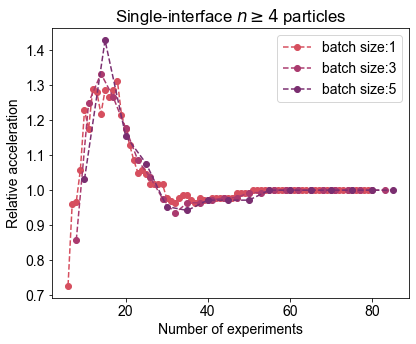

In [22]:
plt.figure(figsize=(6,5))
palette = itertools.cycle(sns.color_palette(palette='flare', n_colors=4))
next(palette)

# This loop adds data from three batch sizes we studied to the plot:
for r in range(len(ucb_scenario_2_runs)):
    color=next(palette)
    merged1 = np.array([j for j in ecucb_scenario_2_runs[r]])
    mu1 = np.mean(merged1, axis=0)-38
    std1 = np.std(merged1, axis=0)
    x1 = np.arange(1,len(merged1[0])+1)*batch_sizes_2[r]+5
    
    merged1p = np.array([j for j in ucb_scenario_2_runs[r]])
    mu1p = np.mean(merged1p, axis=0)-38
    std1p = np.std(merged1p, axis=0)
    x1p = np.arange(1,len(merged1p[0])+1)*batch_sizes_2[r]+5
    
    plt.plot(x1 ,mu1/mu1p, 'o--', label='batch size:'+str(batch_sizes_2[r]),color=color)

plt.legend()
plt.ylabel(r"Relative acceleration")
plt.title('Single-interface $n \geq 4$ particles')
plt.xlabel("Number of experiments")
plt.tight_layout()
plt.savefig('acceleration_2.pdf',dpi=300)
plt.savefig('acceleration_2.png',dpi=300)